   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.05     37.37                27.0       3885.0           661.0   
1    -118.30     34.26                43.0       1510.0           310.0   
2    -117.81     33.78                27.0       3589.0           507.0   
3    -118.36     33.82                28.0         67.0            15.0   
4    -119.67     36.33                19.0       1241.0           244.0   

   population  households  median_income  median_house_value  
0      1537.0       606.0         6.6085            344700.0  
1       809.0       277.0         3.5990            176500.0  
2      1484.0       495.0         5.7934            270500.0  
3        49.0        11.0         6.1359            330000.0  
4       850.0       237.0         2.9375             81700.0  


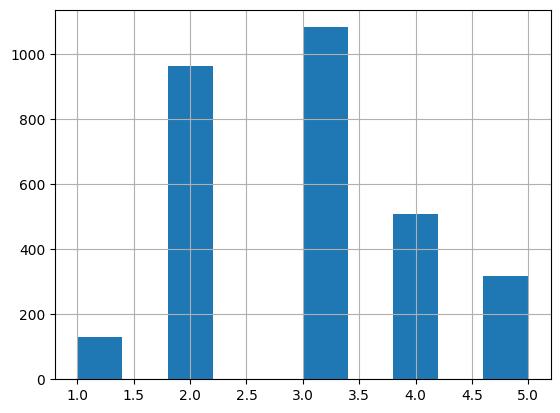

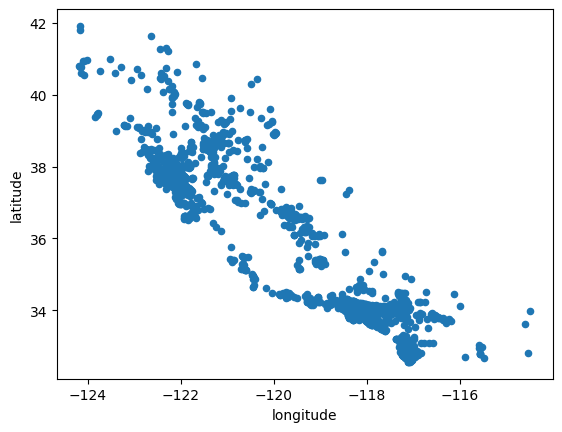

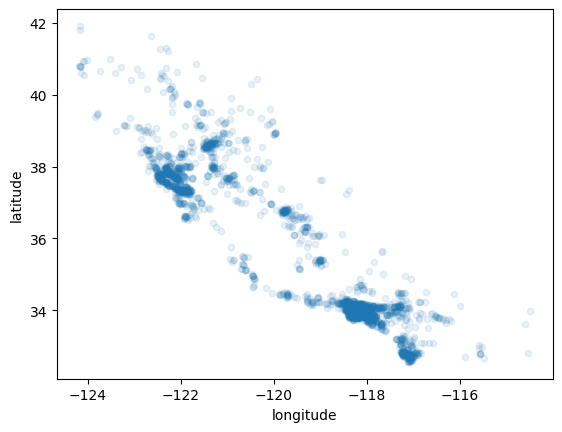

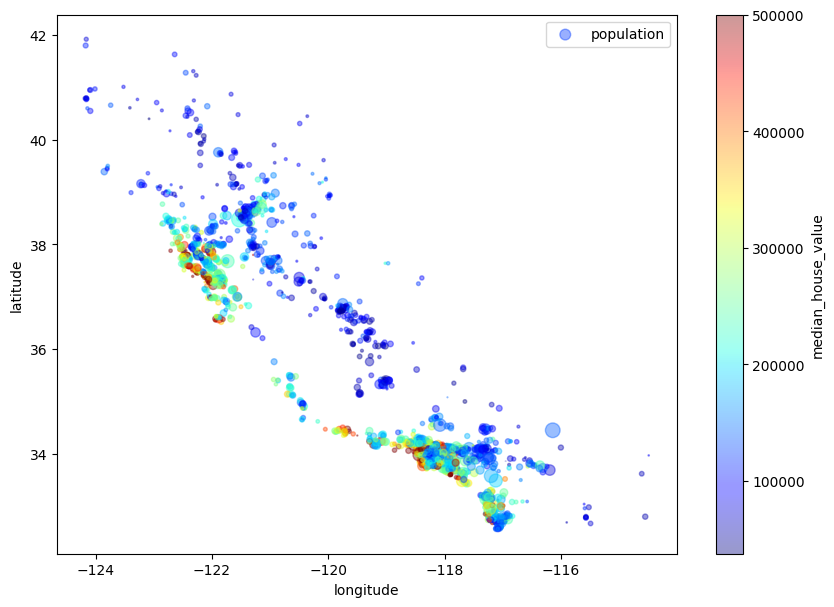

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
def load_housing_data(housing_path="/content/sample_data/"):
    """Loads Housing data into a pandas dataframe.

    # Arguments:
        housing_path: the path where `housing.csv` exists

    # Returns:
        data, pd.DataFrame: the housing data as a pandas dataframe
    """
    data_path = os.path.join(housing_path, "california_housing_test.csv")
    return pd.read_csv(data_path)
def split_train_test(data, test_ratio=0.2):
    """Splits a dataset into train/test using a `test_ratio`.

    # Arguments
        data, pd.DataFrame: the whole dataset.
        test_ratio, float: the percentage taken from the original dataset as a test set.

    # Returns
        train, pd.DataFrame: the training set.
        test, pd.DataFrame: the test set.
    """
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


def test_set_check(identifier, test_ratio=.2):
    """Checks if an instance with `identifier` should be in the test set of overall ratio `test_ratio`

    # Arguments:
        identifier, int: the instance/row identifier (ex. row index from `pd.DataFrame`)
        test_ratio, float \in [0,1]: percentage of test set taken from overall data set.

    # Returns:
        in_test, bool: True if instance should be in the test set, False otherwise.

    # Notes:
        - The CRC32 function converts a varibale-length string into an 8-character string that
        is a text representation of the hexadecimal value of a 32bit binary sequence.
    """
    total_size = 2**32
    hex_repr = crc32(np.int64(identifier)) & 0xffffffff
    in_test = hex_repr < (test_ratio * total_size)
    return in_test


def split_train_test_by_id(data, test_ratio, id_column):
    """Splits a dataframe using hash-based identification

    # Arguments:
        data, pd.DataFrame: the dataframe comprised of an id column and data of interest.
        test_ratio, float \in [0,1]: percentage of test set taken from overall data set.
        id_column, string: column name with identifiers for each row.

    # Returns:
        train, pd.DataFrame: the train set.
        test, pd.DataFrame: the test set.
    """
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


def from_Z_to_N(z):
    """Converts a number from \Bbb{Z} to \Bbb{N}

    # Arguments
        z, integer: in \Bbb{Z}

    # Returns
        n, natural number: in \Bbb{N}
    """
    if z >= 0:
        n = 2 * z
    else:
        n = -2 * z - 1
    return n

def cantor_pairing(n1, n2):
    """Creates a unique number `n` in \Bbb{N} from a tuple (n1,n2) in \Bbb{N}^2

    # Arguments
        n1, natural number: first element of the tuple.
        n2, natural number: second element of the tuple.

    # Returns
        n, natural number: unique index from tuple (n1,n2).
    """
    n = ( ( (n1 + n2) * (n1 + n2 + 1) ) / 2 ) + n2
    return n

def lat_lon_to_index(lat, lon):
    """Converts a tuple of (lat,lon) to a unique index in \Bbb{N}

    # Arguments
        lat, float: latitude.
        lon, float: longitude.

    # Returns
        index, positive int: unique index.

    # Notes
        - 3 steps to do it:
            1. Convert (lat,lon) to \Bbb{Z} by *100.
            2. Convert (lat,lon) from \Bbb{Z} to \Bbb{N} using `from_Z_to_N()`
            3. Create the unique index using `cantor_pairing(_,_)`
    """
    lat, lon = int(lat*100), int(lon*100)
    lat, lon = from_Z_to_N(lat), from_Z_to_N(lon)
    index = cantor_pairing(lat, lon)
    return np.int64(index)

housing = load_housing_data()
print(housing.head())
#housing.info()
#housing.describe()
#housing.hist(bins=50, figsize=(20,15))
#plt.show()
# you can then use the function like this
train_set, test_set = split_train_test(data=housing)
len(train_set), len(test_set)

[test_set_check(i) for i in range(10)]
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(data=housing_with_id, test_ratio=0.2, id_column="index")
train_set.shape, test_set.shape
housing['id'] = housing.apply(lambda row: lat_lon_to_index(row['latitude'], row['longitude']), axis=1)
housing['id'].value_counts()
del(housing['id'])
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(data=housing_with_id, test_ratio=0.2, id_column='id')
train_set.shape, test_set.shape

housing['income_cat'] = pd.cut(x=housing['median_income'], bins=[0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
# visualize the categories
housing['income_cat'].hist()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X=housing, y=housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set['income_cat'].value_counts() / len(strat_test_set)

for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

strat_train_set.shape, strat_test_set.shape

housing = strat_train_set.copy(); housing.shape
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.4, s=housing['population']/100.,
             label='population', figsize=(10, 7), c='median_house_value', cmap=plt.get_cmap(name='jet'), colorbar=True)
plt.legend()


